# NFT GAN

What do the most expensive, most sought-after NFTs have in common? Truth is, we don't know. But using the power of GANs we might be able to find out.

In [1]:
import torch as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as Transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from ai import *
from networks import MyGAN
from tqdm import tqdm
from torchvision.utils import save_image
import os

### Image Hyper Parameters

In [2]:
image_size = 64
batch_size = 64
latent_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

### Load Dataset

In [4]:
train_ds = ImageFolder("new_dataset/", transform=Transforms.Compose([
    Transforms.Resize(image_size),
    Transforms.CenterCrop(image_size),
    Transforms.ToTensor(),
    Transforms.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

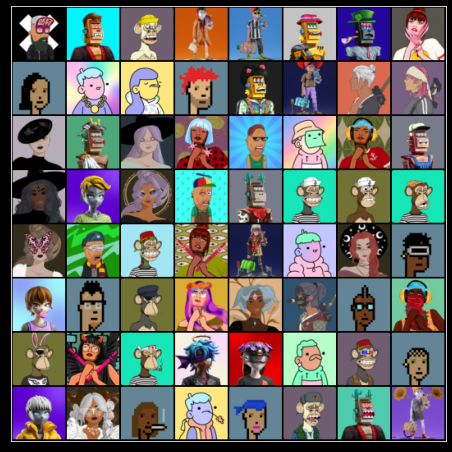

In [6]:
show_batch(train_dl)

torch.Size([64, 3, 64, 64])


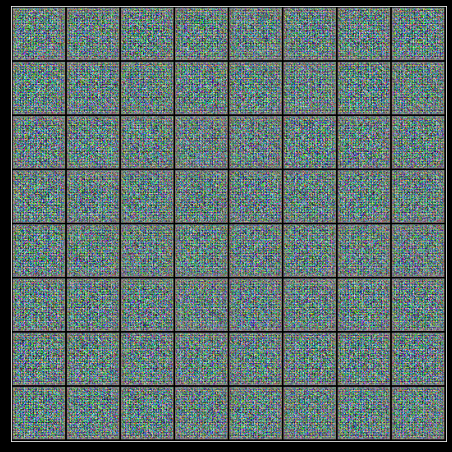

In [7]:
gan_model = MyGAN(latent_size, image_size, batch_size)

xb = T.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = gan_model.generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [8]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [9]:
def save_samples(index, latent_tensors, show=True):
    fake_images = gan_model.generator(latent_tensors)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Load stuff into the device

In [10]:
device = get_default_device()
gan_model.to_device(device)
train_dl = DeviceDataLoader(train_dl, device)

In [11]:
epochs = 200
lr = 0.0004
start_idx = 1

In [12]:
fixed_latent = T.randn(64, latent_size, 1, 1, device=gan_model.device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


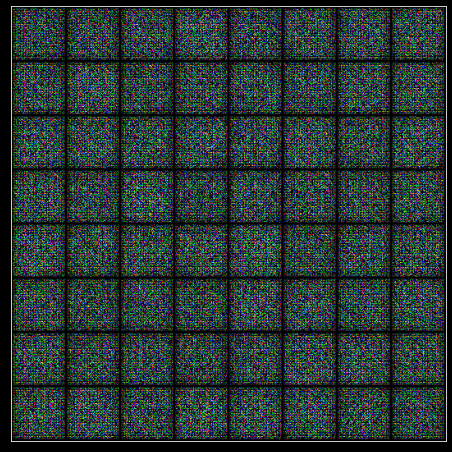

In [13]:
save_samples(0, fixed_latent)

### Train GAN

In [14]:
T.cuda.empty_cache()

print(f"Discriminator parameters count: {count_parameters(gan_model.discriminator)}")
print(f"Generator parameters count: {count_parameters(gan_model.generator)}")

# Losses & scores
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

# Create optimizers
opt_d = T.optim.Adam(gan_model.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = T.optim.Adam(gan_model.generator.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(epochs):
    
    for real_images, _ in tqdm(train_dl):
        # Train discriminator
        loss_d, real_score, fake_score = gan_model.train_discriminator(real_images, opt_d)
        # Train generator
        loss_g = gan_model.train_generator(opt_g)
        
    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)
    
    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

history = losses_g, losses_d, real_scores, fake_scores

Discriminator parameters count: 2765696
Generator parameters count: 3806080


100%|██████████| 1541/1541 [04:37<00:00,  5.55it/s]


Epoch [1/200], loss_g: 2.6900, loss_d: 0.3024, real_score: 0.8587, fake_score: 0.0920
Saving generated-images-0001.png


100%|██████████| 1541/1541 [02:50<00:00,  9.03it/s]


Epoch [2/200], loss_g: 6.1360, loss_d: 0.0239, real_score: 0.9850, fake_score: 0.0079
Saving generated-images-0002.png


100%|██████████| 1541/1541 [02:50<00:00,  9.04it/s]


Epoch [3/200], loss_g: 5.0863, loss_d: 0.0634, real_score: 0.9492, fake_score: 0.0033
Saving generated-images-0003.png


100%|██████████| 1541/1541 [02:49<00:00,  9.09it/s]


Epoch [4/200], loss_g: 5.7821, loss_d: 0.0257, real_score: 0.9920, fake_score: 0.0168
Saving generated-images-0004.png


100%|██████████| 1541/1541 [02:49<00:00,  9.11it/s]


Epoch [5/200], loss_g: 4.9495, loss_d: 0.0137, real_score: 0.9925, fake_score: 0.0060
Saving generated-images-0005.png


100%|██████████| 1541/1541 [02:51<00:00,  9.00it/s]


Epoch [6/200], loss_g: 6.8260, loss_d: 0.0313, real_score: 0.9820, fake_score: 0.0121
Saving generated-images-0006.png


100%|██████████| 1541/1541 [02:49<00:00,  9.08it/s]


Epoch [7/200], loss_g: 17.1779, loss_d: 0.1446, real_score: 0.9326, fake_score: 0.0045
Saving generated-images-0007.png


100%|██████████| 1541/1541 [02:48<00:00,  9.12it/s]


Epoch [8/200], loss_g: 6.9258, loss_d: 0.0050, real_score: 0.9998, fake_score: 0.0048
Saving generated-images-0008.png


100%|██████████| 1541/1541 [02:51<00:00,  8.99it/s]


Epoch [9/200], loss_g: 7.8106, loss_d: 0.0045, real_score: 0.9997, fake_score: 0.0042
Saving generated-images-0009.png


100%|██████████| 1541/1541 [02:52<00:00,  8.94it/s]


Epoch [10/200], loss_g: 4.0462, loss_d: 0.0467, real_score: 0.9734, fake_score: 0.0112
Saving generated-images-0010.png


100%|██████████| 1541/1541 [02:51<00:00,  8.97it/s]


Epoch [11/200], loss_g: 7.9423, loss_d: 0.0087, real_score: 0.9929, fake_score: 0.0013
Saving generated-images-0011.png


100%|██████████| 1541/1541 [02:52<00:00,  8.96it/s]


Epoch [12/200], loss_g: 8.3169, loss_d: 0.0059, real_score: 0.9995, fake_score: 0.0053
Saving generated-images-0012.png


100%|██████████| 1541/1541 [02:49<00:00,  9.07it/s]


Epoch [13/200], loss_g: 7.2875, loss_d: 0.0047, real_score: 0.9977, fake_score: 0.0024
Saving generated-images-0013.png


100%|██████████| 1541/1541 [02:48<00:00,  9.17it/s]


Epoch [14/200], loss_g: 3.6402, loss_d: 0.0421, real_score: 0.9634, fake_score: 0.0010
Saving generated-images-0014.png


100%|██████████| 1541/1541 [02:48<00:00,  9.14it/s]


Epoch [15/200], loss_g: 9.2674, loss_d: 0.0033, real_score: 0.9979, fake_score: 0.0011
Saving generated-images-0015.png


100%|██████████| 1541/1541 [02:48<00:00,  9.16it/s]


Epoch [16/200], loss_g: 9.5476, loss_d: 0.0005, real_score: 0.9999, fake_score: 0.0005
Saving generated-images-0016.png


100%|██████████| 1541/1541 [02:51<00:00,  8.97it/s]


Epoch [17/200], loss_g: 6.7354, loss_d: 0.0088, real_score: 1.0000, fake_score: 0.0087
Saving generated-images-0017.png


100%|██████████| 1541/1541 [02:49<00:00,  9.09it/s]


Epoch [18/200], loss_g: 3.3939, loss_d: 0.1314, real_score: 0.9157, fake_score: 0.0123
Saving generated-images-0018.png


100%|██████████| 1541/1541 [02:48<00:00,  9.13it/s]


Epoch [19/200], loss_g: 13.6820, loss_d: 0.0039, real_score: 0.9962, fake_score: 0.0000
Saving generated-images-0019.png


100%|██████████| 1541/1541 [02:49<00:00,  9.07it/s]


Epoch [20/200], loss_g: 19.3604, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0020.png


100%|██████████| 1541/1541 [02:49<00:00,  9.10it/s]


Epoch [21/200], loss_g: 8.1778, loss_d: 0.0074, real_score: 0.9976, fake_score: 0.0049
Saving generated-images-0021.png


100%|██████████| 1541/1541 [02:49<00:00,  9.08it/s]


Epoch [22/200], loss_g: 5.2573, loss_d: 0.0743, real_score: 0.9511, fake_score: 0.0010
Saving generated-images-0022.png


100%|██████████| 1541/1541 [02:49<00:00,  9.09it/s]


Epoch [23/200], loss_g: 7.6408, loss_d: 0.0235, real_score: 0.9829, fake_score: 0.0054
Saving generated-images-0023.png


100%|██████████| 1541/1541 [02:48<00:00,  9.15it/s]


Epoch [24/200], loss_g: 15.8797, loss_d: 0.0048, real_score: 0.9969, fake_score: 0.0016
Saving generated-images-0024.png


100%|██████████| 1541/1541 [02:48<00:00,  9.16it/s]


Epoch [25/200], loss_g: 6.4264, loss_d: 0.0054, real_score: 0.9955, fake_score: 0.0008
Saving generated-images-0025.png


100%|██████████| 1541/1541 [02:47<00:00,  9.21it/s]


Epoch [26/200], loss_g: 7.1619, loss_d: 0.0005, real_score: 0.9999, fake_score: 0.0005
Saving generated-images-0026.png


100%|██████████| 1541/1541 [02:46<00:00,  9.23it/s]


Epoch [27/200], loss_g: 8.3714, loss_d: 0.0034, real_score: 0.9997, fake_score: 0.0031
Saving generated-images-0027.png


100%|██████████| 1541/1541 [02:47<00:00,  9.18it/s]


Epoch [28/200], loss_g: 19.0437, loss_d: 0.0009, real_score: 1.0000, fake_score: 0.0009
Saving generated-images-0028.png


100%|██████████| 1541/1541 [02:47<00:00,  9.21it/s]


Epoch [29/200], loss_g: 8.2967, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0029.png


100%|██████████| 1541/1541 [02:48<00:00,  9.16it/s]


Epoch [30/200], loss_g: 7.0747, loss_d: 0.0043, real_score: 0.9999, fake_score: 0.0041
Saving generated-images-0030.png


100%|██████████| 1541/1541 [02:47<00:00,  9.18it/s]


Epoch [31/200], loss_g: 10.0473, loss_d: 0.0024, real_score: 0.9978, fake_score: 0.0002
Saving generated-images-0031.png


100%|██████████| 1541/1541 [02:51<00:00,  9.00it/s]


Epoch [32/200], loss_g: 12.0507, loss_d: 0.0019, real_score: 0.9999, fake_score: 0.0017
Saving generated-images-0032.png


100%|██████████| 1541/1541 [02:49<00:00,  9.10it/s]


Epoch [33/200], loss_g: 10.6155, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-0033.png


100%|██████████| 1541/1541 [02:49<00:00,  9.10it/s]


Epoch [34/200], loss_g: 11.1119, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-0034.png


100%|██████████| 1541/1541 [02:48<00:00,  9.14it/s]


Epoch [35/200], loss_g: 5.4886, loss_d: 0.0763, real_score: 0.9418, fake_score: 0.0010
Saving generated-images-0035.png


100%|██████████| 1541/1541 [02:49<00:00,  9.12it/s]


Epoch [36/200], loss_g: 8.4704, loss_d: 0.0033, real_score: 0.9981, fake_score: 0.0013
Saving generated-images-0036.png


100%|██████████| 1541/1541 [02:48<00:00,  9.13it/s]


Epoch [37/200], loss_g: 5.5788, loss_d: 0.0005, real_score: 0.9999, fake_score: 0.0004
Saving generated-images-0037.png


100%|██████████| 1541/1541 [02:49<00:00,  9.10it/s]


Epoch [38/200], loss_g: 6.9375, loss_d: 0.0013, real_score: 0.9999, fake_score: 0.0011
Saving generated-images-0038.png


100%|██████████| 1541/1541 [02:50<00:00,  9.05it/s]


Epoch [39/200], loss_g: 13.7849, loss_d: 0.0025, real_score: 0.9999, fake_score: 0.0023
Saving generated-images-0039.png


100%|██████████| 1541/1541 [02:49<00:00,  9.09it/s]


Epoch [40/200], loss_g: 9.4709, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0040.png


100%|██████████| 1541/1541 [02:50<00:00,  9.03it/s]


Epoch [41/200], loss_g: 8.7370, loss_d: 0.0152, real_score: 1.0000, fake_score: 0.0144
Saving generated-images-0041.png


100%|██████████| 1541/1541 [02:49<00:00,  9.07it/s]


Epoch [42/200], loss_g: 13.1820, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving generated-images-0042.png


100%|██████████| 1541/1541 [02:48<00:00,  9.12it/s]


Epoch [43/200], loss_g: 18.1130, loss_d: 0.0022, real_score: 1.0000, fake_score: 0.0021
Saving generated-images-0043.png


100%|██████████| 1541/1541 [02:49<00:00,  9.11it/s]


Epoch [44/200], loss_g: 24.0271, loss_d: 0.0007, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-0044.png


100%|██████████| 1541/1541 [02:49<00:00,  9.07it/s]


Epoch [45/200], loss_g: 10.0571, loss_d: 0.0023, real_score: 0.9998, fake_score: 0.0021
Saving generated-images-0045.png


100%|██████████| 1541/1541 [02:47<00:00,  9.20it/s]


Epoch [46/200], loss_g: 6.0830, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0046.png


100%|██████████| 1541/1541 [02:49<00:00,  9.12it/s]


Epoch [47/200], loss_g: 20.3287, loss_d: 0.0007, real_score: 1.0000, fake_score: 0.0007
Saving generated-images-0047.png


100%|██████████| 1541/1541 [02:48<00:00,  9.16it/s]


Epoch [48/200], loss_g: 6.8163, loss_d: 0.0018, real_score: 0.9987, fake_score: 0.0006
Saving generated-images-0048.png


100%|██████████| 1541/1541 [02:48<00:00,  9.16it/s]


Epoch [49/200], loss_g: 8.7231, loss_d: 0.0026, real_score: 1.0000, fake_score: 0.0026
Saving generated-images-0049.png


100%|██████████| 1541/1541 [02:49<00:00,  9.11it/s]


Epoch [50/200], loss_g: 8.5925, loss_d: 0.0004, real_score: 0.9997, fake_score: 0.0001
Saving generated-images-0050.png


100%|██████████| 1541/1541 [02:48<00:00,  9.17it/s]


Epoch [51/200], loss_g: 12.9640, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0051.png


100%|██████████| 1541/1541 [02:48<00:00,  9.16it/s]


Epoch [52/200], loss_g: 0.0021, loss_d: 1.1443, real_score: 0.5504, fake_score: 0.0004
Saving generated-images-0052.png


100%|██████████| 1541/1541 [02:48<00:00,  9.17it/s]


Epoch [53/200], loss_g: 19.9131, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0053.png


100%|██████████| 1541/1541 [02:48<00:00,  9.17it/s]


Epoch [54/200], loss_g: 9.1785, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0054.png


100%|██████████| 1541/1541 [02:48<00:00,  9.16it/s]


Epoch [55/200], loss_g: 9.4854, loss_d: 0.0394, real_score: 1.0000, fake_score: 0.0371
Saving generated-images-0055.png


100%|██████████| 1541/1541 [02:47<00:00,  9.22it/s]


Epoch [56/200], loss_g: 9.8761, loss_d: 0.1531, real_score: 0.8932, fake_score: 0.0000
Saving generated-images-0056.png


100%|██████████| 1541/1541 [02:47<00:00,  9.18it/s]


Epoch [57/200], loss_g: 11.4115, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-0057.png


100%|██████████| 1541/1541 [02:49<00:00,  9.09it/s]


Epoch [58/200], loss_g: 13.0491, loss_d: 0.1761, real_score: 0.9096, fake_score: 0.0010
Saving generated-images-0058.png


100%|██████████| 1541/1541 [02:52<00:00,  8.94it/s]


Epoch [59/200], loss_g: 18.2624, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-0059.png


100%|██████████| 1541/1541 [02:51<00:00,  8.99it/s]


Epoch [60/200], loss_g: 15.5516, loss_d: 0.0042, real_score: 0.9959, fake_score: 0.0000
Saving generated-images-0060.png


100%|██████████| 1541/1541 [02:48<00:00,  9.16it/s]


Epoch [61/200], loss_g: 16.3263, loss_d: 0.0004, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-0061.png


100%|██████████| 1541/1541 [02:47<00:00,  9.18it/s]


Epoch [62/200], loss_g: 1.1406, loss_d: 0.9537, real_score: 0.6464, fake_score: 0.0000
Saving generated-images-0062.png


100%|██████████| 1541/1541 [02:48<00:00,  9.12it/s]


Epoch [63/200], loss_g: 5.3821, loss_d: 0.0017, real_score: 0.9997, fake_score: 0.0014
Saving generated-images-0063.png


100%|██████████| 1541/1541 [02:48<00:00,  9.16it/s]


Epoch [64/200], loss_g: 14.7587, loss_d: 0.0061, real_score: 0.9971, fake_score: 0.0030
Saving generated-images-0064.png


100%|██████████| 1541/1541 [02:49<00:00,  9.09it/s]


Epoch [65/200], loss_g: 9.7081, loss_d: 0.0062, real_score: 1.0000, fake_score: 0.0061
Saving generated-images-0065.png


100%|██████████| 1541/1541 [02:49<00:00,  9.08it/s]


Epoch [66/200], loss_g: 44.9730, loss_d: 0.0009, real_score: 0.9994, fake_score: 0.0002
Saving generated-images-0066.png


100%|██████████| 1541/1541 [02:49<00:00,  9.10it/s]


Epoch [67/200], loss_g: 13.8394, loss_d: 0.0236, real_score: 0.9835, fake_score: 0.0028
Saving generated-images-0067.png


100%|██████████| 1541/1541 [02:47<00:00,  9.19it/s]


Epoch [68/200], loss_g: 13.6941, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0068.png


100%|██████████| 1541/1541 [02:48<00:00,  9.16it/s]


Epoch [69/200], loss_g: 16.1300, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0069.png


 35%|███▌      | 541/1541 [01:03<01:57,  8.50it/s]


KeyboardInterrupt: 